In [1]:
!conda info


     active environment : dov_env
    active env location : /home/sameed/anaconda3/envs/dov_env
            shell level : 2
       user config file : /home/sameed/.condarc
 populated config files : /home/sameed/.condarc
          conda version : 4.13.0
    conda-build version : 3.21.8
         python version : 3.9.12.final.0
       virtual packages : __cuda=11.7=0
                          __linux=5.13.0=0
                          __glibc=2.31=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /home/sameed/anaconda3  (writable)
      conda av data dir : /home/sameed/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/sameed/a

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd
import os

from itertools import cycle

sns.set_theme(style="white", palette = None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
conda install seaborn

Solving environment: done

## Package Plan ##

  environment location: /home/sameed/anaconda3/envs/dov_env

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.4.26  |       h06a4308_0         124 KB
    certifi-2022.6.15          |  py310h06a4308_0         153 KB
    ------------------------------------------------------------
                                           Total:         277 KB

The following NEW packages will be INSTALLED:

  seaborn            pkgs/main/noarch::seaborn-0.11.2-pyhd3eb1b0_0

The following packages will be UPDATED:

  openssl               anaconda::openssl-1.1.1o-h7f8727e_0 --> pkgs/main::openssl-1.1.1p-h5eee18b_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                  anaconda --> pkgs/main
  certifi                                

In [38]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveshow(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

In [42]:
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [40]:
data_dir = os.path.join(os.path.abspath('.'), '/home/sameed/projects/DovProject/dov-audio-filter/data')
# 10 subjects
subject_names = ['s' + str(i) for i in range(1,10+1)]

# 2 session rooms
trial_names_base = [f'{t}_trial{i}' 
                    for t in ['downstairs_nowall', 'downstairs_wall',
                              'upstairs_nowall', 'upstairs_wall']
                    for i in range(1,3)]

trial_names = [os.path.join(s, s + '_' + t).replace('\\','/') 
               for s in subject_names
               for t in trial_names_base]
angle_names = [alph[0] + num[0] + '_' + alph[1] + '_' + num[1]  
               for alph in [('A', '1'), ('B', '3'), ('C', '5')]
               for num in [(str(i),str(45*i)) for i in range(3)]]
# recording paths
recording_paths = [os.path.join(data_dir, t,a).replace('\\','/') for t in trial_names 
                                              for a in angle_names]
recording_paths_rel = [(s,t,a) for s in subject_names
                               for t in trial_names_base 
                               for a in angle_names]

print(*zip(recording_paths_rel, recording_paths))

(('s1', 'downstairs_nowall_trial1', 'A0_1_0'), '/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/A0_1_0') (('s1', 'downstairs_nowall_trial1', 'A1_1_45'), '/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/A1_1_45') (('s1', 'downstairs_nowall_trial1', 'A2_1_90'), '/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/A2_1_90') (('s1', 'downstairs_nowall_trial1', 'B0_3_0'), '/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/B0_3_0') (('s1', 'downstairs_nowall_trial1', 'B1_3_45'), '/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/B1_3_45') (('s1', 'downstairs_nowall_trial1', 'B2_3_90'), '/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/B2_3_90') (('s1', 'downstairs_nowall_trial1', 'C0_5_0'), '/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/

In [31]:
audio_files=glob.glob('../home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/A0_1_0/*/*.wav')

In [43]:
recordings_of_interest_0 = [os.path.join(recording_paths[0], f'recording0_0_{i}.wav') for i in range(1,5)]
audio_files_0 = [Audio.fromfile(r) for r in recordings_of_interest_0]
four_channels_0 = [a.data for a in audio_files_0]
gcc_phat_data_0 = [gcc_phat(four_channels_0[i],four_channels_0[j], fs = audio_files_0[0].rate, max_tau=0.236 * 1e-3, interp=1)
     for i in range(len(four_channels_0))
     for j in range(i+1,len(four_channels_0))]

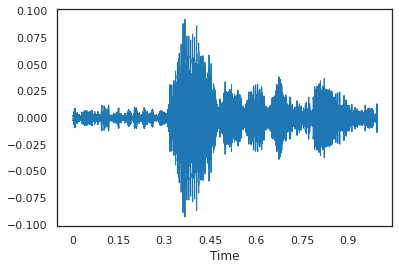

In [44]:
audio_files_0[0].plot_wave()

In [48]:
ipd.Audio(audio_files_0[0])

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [50]:
y,sr = librosa.load(audio_files_0[0])

TypeError: Invalid file: <__main__.Audio object at 0x7effb1cd3f10>

/tmp/ipykernel_245233/840359558.py:14: FutureWarning: Pass n_fft=2400 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)


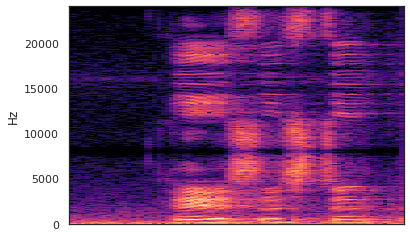

In [54]:
audio_files_0[0].plot_spectrum()

In [53]:
import wave
w = wave.open('/home/sameed/projects/DovProject/dov-audio-filter/data/s1/s1_downstairs_nowall_trial1/A0_1_0/recording0_0_0.wav', 'r')
for i in range(w.getnframes()):
    frame = w.readframes(i)
    print (frame)

b''
b'A\x00'
b'?\x00>\x00'
b'=\x00;\x008\x00'
b'5\x001\x00.\x00)\x00'
b'#\x00\x1d\x00\x1a\x00\x16\x00\x13\x00'
b'\x12\x00\x13\x00\x14\x00\x16\x00\x19\x00\x19\x00'
b'\x1d\x00\x1f\x00&\x00,\x005\x00;\x00=\x00'
b'?\x00=\x00=\x00:\x009\x007\x005\x000\x00'
b'+\x00#\x00\x1d\x00\x18\x00\x13\x00\x11\x00\x0e\x00\n\x00\x06\x00'
b'\x00\x00\xfe\xff\xfa\xff\xf8\xff\xf4\xff\xef\xff\xeb\xff\xe7\xff\xe5\xff\xe7\xff'
b'\xe8\xff\xea\xff\xe7\xff\xe1\xff\xdb\xff\xd3\xff\xcd\xff\xcb\xff\xcc\xff\xca\xff\xc7\xff'
b'\xc0\xff\xb7\xff\xae\xff\xa9\xff\xa4\xff\xa5\xff\xa5\xff\xa7\xff\xa6\xff\xa5\xff\x9f\xff\x9a\xff'
b'\x94\xff\x8c\xff\x86\xff\x80\xffy\xffr\xffl\xffh\xfff\xffd\xffe\xffg\xffk\xff'
b'm\xffq\xffu\xffw\xffy\xff|\xff\x81\xff\x86\xff\x8e\xff\x95\xff\x9a\xff\x9f\xff\xa0\xff\xa4\xff'
b'\xa8\xff\xad\xff\xb5\xff\xba\xff\xbd\xff\xbf\xff\xbd\xff\xba\xff\xb9\xff\xb6\xff\xb4\xff\xaf\xff\xaa\xff\xa7\xff\xa3\xff'
b'\xa1\xff\xa2\xff\xa2\xff\xa1\xff\xa0\xff\x9d\xff\x9b\xff\x9a\xff\x9b\xff\x9e\xff\xa0\xff\x9f\xff\x9

b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


In [57]:
audio_files_0[0].play()

AttributeError: 'function' object has no attribute 'Audio'

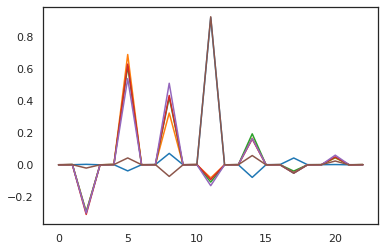

In [60]:
for i in range(len(gcc_phat_data_0)):
    plt.plot(gcc_phat_data_0[i][1])

In [4]:
librosa.load("../data/example_wav/180/channel_1.wav")

(array([ 0.00164215,  0.0025193 ,  0.00226117, ..., -0.0013886 ,
        -0.00115264, -0.00101046], dtype=float32),
 22050)

In [9]:
librosa.load("../data/example_wav/180/channel_1.wav")

(array([ 0.00164215,  0.0025193 ,  0.00226117, ..., -0.0013886 ,
        -0.00115264, -0.00101046], dtype=float32),
 22050)

AttributeError: 'tuple' object has no attribute 'shape'